# SCIKIT LEARN / MODEL SELECTION

[video 21](https://www.youtube.com/watch?v=w_bLGK4Pteo)

- Comment creer un trainset et un testset
- Valider un model avec des techniques de cross validation
- Ameliorer un model par grid search
- Learning curves

Entrainer / Optimiser / Evaluer un model de machine learning

## 1. Trainset / Testset

__Ne jamais evaluer la performance d'un model sur les memes donnees qui ont servi a son entrainement__

On divise toujours notre dataset en deux parties :
1. Un trainset, dont les donnees servent a l'apprentissage de la machine (80% des data) : fit(Xtrain, ytrain) 
2. Un testset, qui permet d'evaluer les performances du model (20% des data) : score(Xtest, ytest)

sklearn > model_selection > train_test_split

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

(150, 4)


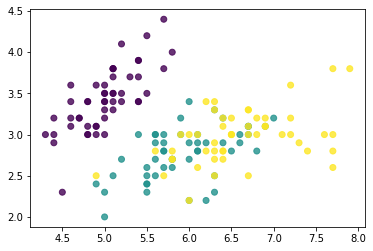

In [4]:
iris = load_iris()

X = iris.data
y = iris.target

print(X.shape)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.8)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #test_size : part de donnees de tests

print('Train set shape : ', X_train.shape)
print('Test set shape : ', X_test.shape)

Train set shape :  (120, 4)
Test set shape :  (30, 4)


Par defaut, a chaque fois qu'on utilise la fonction, elle prend des elements aleatoire dans le dataset. Si on le souhaite, on peut "fixer l'aleatoire", en utilisant le parametre "random_state="

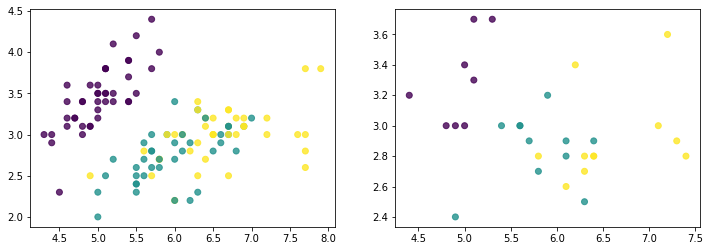

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5) #test_size : part de donnees de tests

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, alpha=0.8)
plt.subplot(1, 2, 2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, alpha=0.8)
plt.show()

In [13]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
print('Eval model sur train data : ', model.score(X_train, y_train))
print('Eval model sur test data : ', model.score(X_test, y_test))

Eval model sur train data :  1.0
Eval model sur test data :  0.9


## 2. Validation set

Le job de DS va consiste a toujours ameliorer la qualite de notre model. Pour ca, on va jouer sur les hyper parametres de notre model.

On peut, par exemple, tuner le n_neighbors pour ameliorer le score du Test set. Mais si on fine tune sur le test set, alors on ne pourra plus utiliser ce set pour la validation finale de notre model (evidemment)

Il nous faudra donc un Validation set. En realite, c'est sur ce Validation set, qu'on va faire le tuning. Et, on gardera de cote le test set pour le Test "final"

- On entraine deux modele avec des hyperfeatures differentes sur le meme trainset.
- On les evalue sur le Validation set
- On retient celui qui a le meilleur resultat
- On le test sur le Test set

Pour eviter que notre decoupage du dataset initial influe sur l'entrainement de notre model, on va utiliser ce qu'on appelle de la Cross Validation

## 3. Cross Validation

Entrainer et valider le modele, sur plusieurs decoupes possibles du Train set

Exemple : On divise notre trainset en 5 parties. L'une d'elle celle de validation set. On fait des tests en changeant a chaque fois le set qui sert a la validation et on compare les resultats de nos deux modeles sur tous ces possibles decoupages. Ensuite on fera la moyenne des 5 score qu'on obtient pour chaque modele et on prend le modele qui aura la meilleure moyenne. (StratifiedKFold technique)

Il existe plusieurs maniere de faire de la cross validation.

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy') # cv = nombre de split du trainset

array([1.        , 1.        , 1.        , 0.95833333, 0.95833333])

Donne 5 scores : pour nos 5 splits

In [15]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring='accuracy').mean()

0.9833333333333334

Il suffit de changer notre modele (ou ses hyper parametre), cf. le premier argument de la fonction, pour evaluer/cross valider ces modeles

Pour evaluer tout ca, on peut coder une boucle de test :

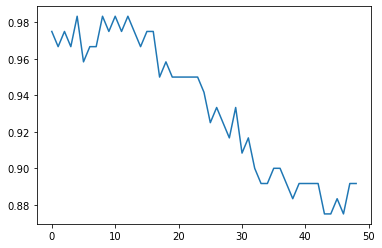

In [17]:
val_score = []

for i in range(1, 50) :
    val_score.append(cross_val_score(KNeighborsClassifier(n_neighbors=i), X_train, y_train, cv=5, scoring='accuracy').mean())

plt.plot(val_score)

### 3.1. Validation Curve

Teste toutes les valeurs pour l'hyper parametre donne. Calcule le score pour le Train set et le Val set grace a la Cross Validation

In [18]:
from sklearn.model_selection import validation_curve

In [22]:
model = KNeighborsClassifier()

k = np.arange(1, 50) # nombre de valeur qu'on va tester pour cet hyper parametre

train_score, val_score = validation_curve(model, X = X_train, y = y_train, param_name = 'n_neighbors', param_range = k, cv=5) # Warning si arguments seulement positionnels. Mieux vaut les nnommer
print('Train score shape : ', train_score.shape)
print('Val score shape : ', val_score.shape)

Train score shape :  (49, 5)
Val score shape :  (49, 5)


- 49 lignes pour les 49 valeurs de l'hyperparametre qu'on teste
- 5 colonnes pour les 5 validation set definis par le parametre CV

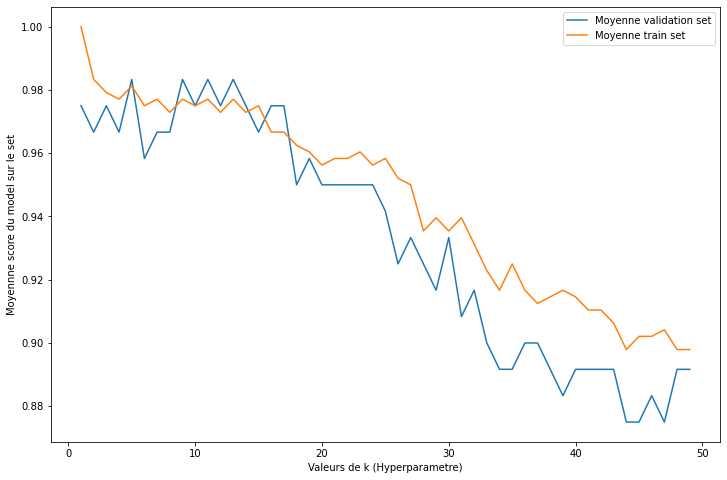

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(k, val_score.mean(axis=1), label = 'Moyenne validation set') # affiche la moyenne de valscore pour les differentes valeurs de l'hyperparametre
plt.plot(k, train_score.mean(axis=1), label = 'Moyenne train set')
plt.xlabel('Valeurs de k (Hyperparametre)')
plt.ylabel('Moyennne score du model sur le set')
plt.legend()
plt.show()

Permet d'identifier les cas d'overfit. C'est a dire quand la machine a tente de trop se perfectionner sur le trainset.

Ca donne un tres bon score en trainset et un moins bon en validation set

### 3.2. Tester toutes les combinaisons d'Hyperparametre (GridsearchCV)

Construit une grille de modeles avec toutes les combinaisons d'hyperparametres present dans param_grid

In [31]:
from sklearn.model_selection import GridSearchCV

In [39]:
param_grid = {'n_neighbors' : np.arange(1, 20),
                'metric' : ['euclidian', 'manhattan']}# Dictionnaire qui contient les differents hyper parametre a regler

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
# On a une grille qui contient plusieurs Estimateurs (modele mathematique)
grid.fit(X_train, y_train) # On les entraine comme un estimateur simple

/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'manhattan'],
                         'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])})

In [40]:
grid.best_score_ #On appelle le parametre du best score

0.975

In [41]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 2}

In [43]:
# ON peut sauvegarder notre best model
model = grid.best_estimator_
model.score(X_test, y_test)

0.8666666666666667

In [44]:
from sklearn.metrics import confusion_matrix

In [45]:
confusion_matrix(y_test, model.predict(X_test))

array([[8, 0, 0],
       [0, 9, 2],
       [0, 2, 9]])

- Les 8 fleurs de la classe 1 ont bien ete rangee dans la classe 1.
- Parmi les 11 fleurs de la classe 2, 9 ont bien ete range. 2 Furent rangees dans la classe 3
- Pour la classe 3, 9 furent bien rangees, et 2 non.

## 4. Les courbes d'apprentissage (learnin curve)

Notre model pourrait-il encore mieux apprendre, si on lui donnait encore plus de donnees ?

Evolution des performances du model, par rapport a la quantite de donnees qu'on lui fournit

In [46]:
from sklearn.model_selection import learning_curve

In [49]:
np.linspace(0.2, 1, 5)

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [55]:
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.1, 1, 5) ,cv = 5) # train_sizes : quantite de donnees necessaire a l'apprentissage (en %)
# train_sizes = np.linspace(0.2, 1, 5) : 20% du dataset mini. 100% max. Avec 5 decoupage possible parmi ca

In [56]:
print(N) # Taille des differents echantillons

[ 9 31 52 74 96]


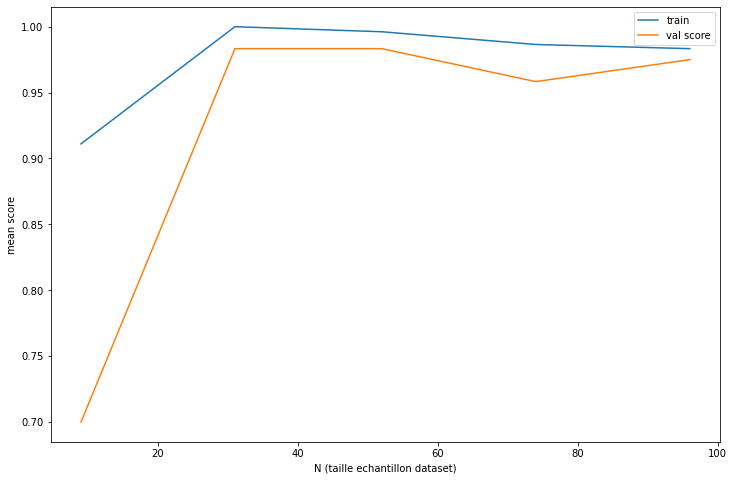

In [57]:
plt.figure(figsize=(12,8))
plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'val score')
plt.xlabel('N (taille echantillon dataset)')
plt.ylabel('mean score')
plt.legend()
plt.show()

# Synthese

1. Commencer toujours par diviser le dataset avec la fonction traintestsplit
2. Ensuite, on peut utiliser le gridsearch pour trouver les meilleurs hyperparametres pour notre model
3. Utiliser les courbes de validation et d'apprentissage pour verifier qu'on n'est pas en Overfit, ni qu'on ne collecte pas trop de data

# Exercice

Sur le dataset du Titanic :

1. Il faudrait commencer par creer un trainset et un testset puis evaluer
2. Avec Gridsearch, trouver les meilleurs hyperparametres, n_neighbors, metric et weights
3. Est-ce que collecter plus de donnees serait plus utile ?

## 1. Preparation du dataset
- chargement
- nettoyage 
- division en features et target pour apprentissage supervise

In [37]:
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [38]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [39]:
titanic.shape

(891, 15)

In [40]:
titanic.drop(['embarked', 'parch', 'sibsp', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], axis=1, inplace=True)
titanic.head()

,survived,pclass,sex,age,fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [41]:
titanic['sex'].replace(['male', 'female'], [0,1], inplace = True)
titanic.head()

,survived,pclass,sex,age,fare
0,0,3,0,22.0,7.2500
1,1,1,1,38.0,71.2833
2,1,3,1,26.0,7.9250
3,1,1,1,35.0,53.1000
4,0,3,0,35.0,8.0500


In [42]:
titanic.isna().sum()

survived      0
pclass        0
sex           0
age         177
fare          0
dtype: int64

In [43]:
titanic.dropna(axis=0, inplace=True)
titanic.shape

(714, 5)

In [44]:
# sns.pairplot(titanic)

In [45]:
# On cree le dataset de features pour l'apprentissage
x = titanic[['pclass', 'sex', 'age']]
x.shape

(714, 3)

In [46]:
# On cree la target variable globale du dataset
y = titanic['survived']
y.shape

(714,)

## Division du dataset pour entrainement, validation et test

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 5) # On fixe le random state pour pouvoir tester un peu
print('Taille ds globale : ', x.shape)
print('Taille trainset', X_train.shape)
print('Taille testset', X_test.shape)

Taille ds globale :  (714, 3)
Taille trainset (571, 3)
Taille testset (143, 3)


#### GridsearchCV sans warning

In [51]:
param_grid = {'n_neighbors' : np.arange(1, 20)
               }# Dictionnaire qui contient les differents hyper parametre a regler
               # Exceptions si j'utilise :  'metric' : ['euclidian', 'manhattan']

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
# On a une grille qui contient plusieurs Estimateurs (modele mathematique)
grid.fit(X_train, y_train) # On les entraine comme un estimateur simple

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [52]:
grid.best_score_

0.7601372997711671

In [53]:
grid.best_params_

{'n_neighbors': 9}

#### GridSearchCV comme demande

In [57]:
param_grid = {'n_neighbors' : np.arange(1, 20), 'metric' : ['euclidian', 'manhattan'], 'weights' : ['uniform', 'distance']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
# On a une grille qui contient plusieurs Estimateurs (modele mathematique)
grid.fit(X_train, y_train) # On les entraine comme un estimateur simple

/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1157, in fit
    return self._fit(X)
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 350, in _fit
    self._check_algorithm_metric()
  File "/home/maximorose/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 332, in _check_algorithm_metric
    raise ValueError("Metric '%s' not valid. Use "
ValueError: Metric 'euclidian' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']})

In [58]:
grid.best_score_

0.7828985507246375

In [59]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}

In [60]:
model = grid.best_estimator_
model.score(X_test, y_test)

0.7832167832167832

## Courbe d'apprentissage

In [64]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

In [65]:
N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.1, 1, 5) ,cv = 5) # train_sizes : quantite de donnees necessaire a l'apprentissage (en %)
# train_sizes = np.linspace(0.2, 1, 5) : 20% du dataset mini. 100% max. Avec 5 decoupage possible parmi ca

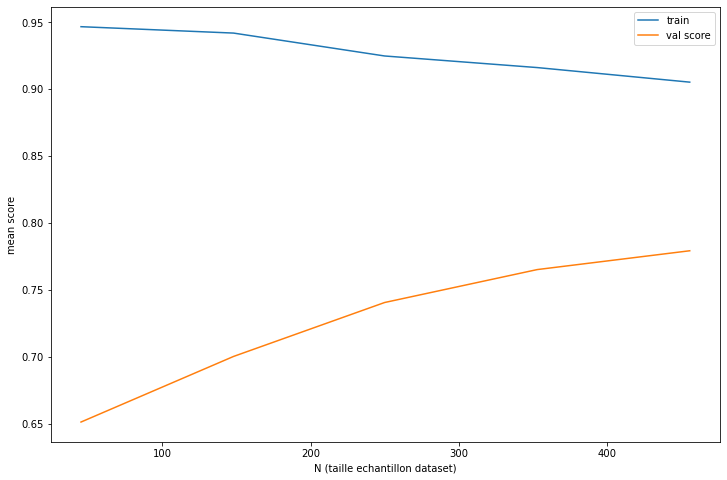

In [66]:
plt.figure(figsize=(12,8))
plt.plot(N, train_score.mean(axis=1), label = 'train')
plt.plot(N, val_score.mean(axis=1), label = 'val score')
plt.xlabel('N (taille echantillon dataset)')
plt.ylabel('mean score')
plt.legend()
plt.show()

__Il nous faut plus de donees !!__